# Elevated-Plus Maze Analysis

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.style as style
import Core
import analysis_utils as au

from scipy import stats
from plotly import tools
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex

# These imports are for testing purposes
import TestDataFrames as TDF
from timeit import default_timer as timer

plotly.offline.init_notebook_mode(connected=True);
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### Import a CSV of raw data, and store it in a dataframe
- ##### Just like the MATLAB version, `detect_ca_transients_mossy()` returns a z-scored dataframe, AUC dataframe, and a cell transients dataframe
- ##### Finally, we name all the columns in each dataframe as such: $neuron_1, neuron_2, neuron_3, \ldots, neuron_n$

In [2]:
data = pd.read_csv('~/d87EPMraw.csv', header=None)

start = timer()
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
end = timer()

z_scored_dataframe.columns = ['neuron' + str(i) for i in range(1, len(z_scored_dataframe.columns)+1)]
AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
cell_transients_dataframe.columns = ['neuron' + str(i) for i in range(1, len(cell_transients_dataframe.columns)+1)]

### Begin with a simple correlation heatmap to get our bearings

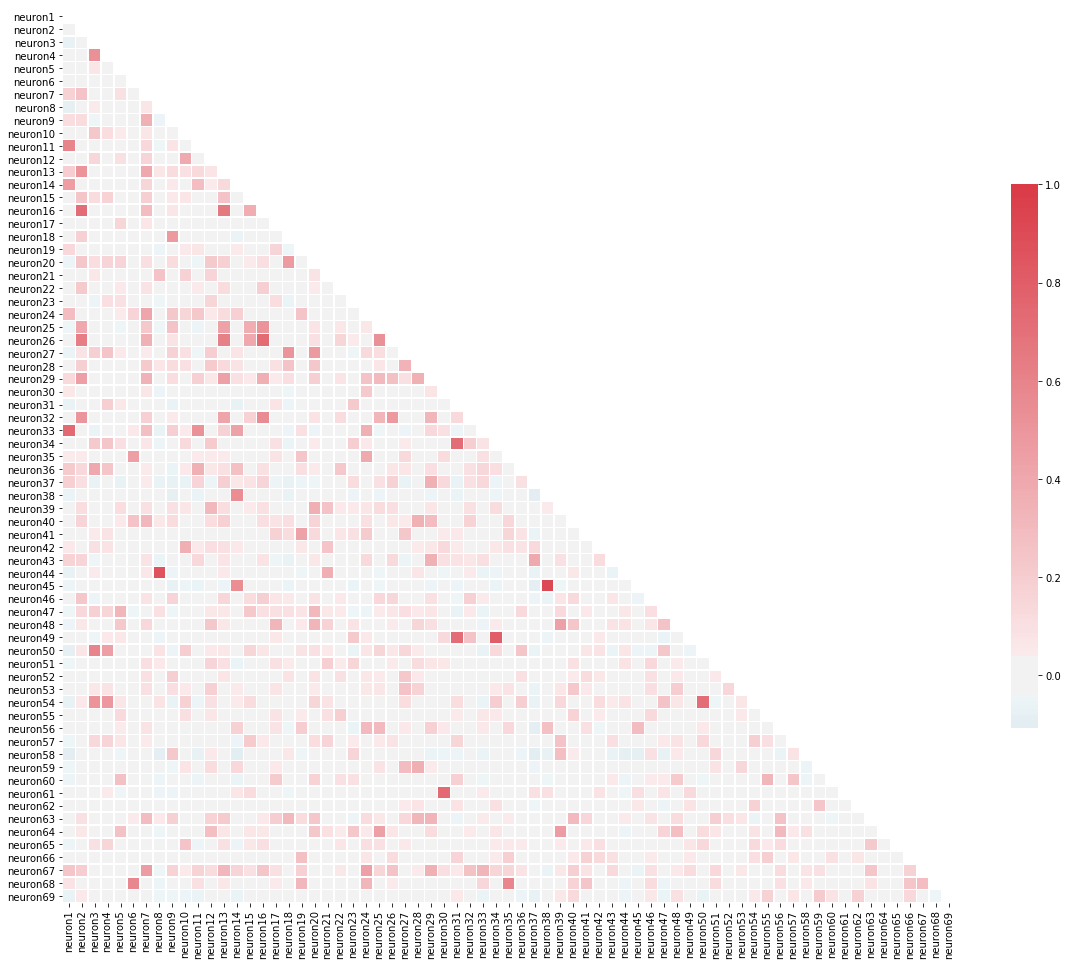

In [3]:
# Generate a mask for the upper triangle
mask = np.zeros_like(cell_transients_dataframe.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cell_transients_dataframe.corr(), mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Next, we assign a correlation value of interest, and we loop through our entire cell transients dataframe to find pairs of neurons that have that correlation value, or greater
- #### Finally, we print out the total amount of correlated pairs of neurons found in the cell transients dataframe for drd87

In [4]:
correlated_pairs_dict = dict()

# Find and all pairs of neurons that have a specified correlation and return a nested dictionary of them
COR_VAL = 0.3
corr_pairs_of_neurons = 0
columns = cell_transients_dataframe.columns.tolist()
for i in range(0, len(columns)):
    for j in range(i+1, len(columns)):
        r_value = np.corrcoef(cell_transients_dataframe[columns[i]], cell_transients_dataframe[columns[j]])[0][1]
        if abs(r_value) >= COR_VAL:
            corr_pairs_of_neurons += 1
            if columns[i] not in correlated_pairs_dict:
                correlated_pairs_dict[columns[i]] = {columns[j]:r_value}
            else: 
                correlated_pairs_dict[columns[i]][columns[j]] = r_value

print("There are {} correlated pairs of neurons".format(corr_pairs_of_neurons))

There are 92 correlated pairs of neurons


### According to the heatmap, neuron 38 and neuron 45 have are highly correlated   
#### We use a homebrewed function to compute the correlation of neuron 38 and 45, as well as plotting them on a scotter plot
- Note that our homebrewed function, `neuron_scatter_plot_with_reg()`, returns two objects:
 - `fig` - an object that tells plotly how and what to plot on the scatter plot
 - `r_value` - the correlation coefficient of the two neurons passed into the function, `neuron_scatter_plot_with_reg()`

In [8]:
fig, r_value = au.neuron_scatter_plot_with_reg('neuron38', 'neuron45', cell_transients_dataframe)
print("Correlation(neuron38, neuron45) = {}".format(r_value))
plotly.offline.iplot(fig)
au.neuron_line_plot('neuron38', 'neuron45', cell_transients_dataframe)

# Scatter plot using Seaborn library (includes confidence band)
# sns.lmplot(x='neuron38', y='neuron45', data=cell_transients_dataframe[['neuron38', 'neuron45']], size=10);
# plt.ylim(0, None);
# plt.xlim(0, None);

Correlation(neuron38, neuron45) = 0.9199946955038318


### We create a clustermap of all the neurons in the cell transients dataframe using the centroid method, 
$$dist(s,t)= \mid\mid c_s - c_t \mid\mid_2$$
##### where $c_s$ and $c_t$ are the centroids of clusters and $s$ and $t$, respecitvely. When two clusters $s$ and $t$ are combined into a new cluster $u$ the new centroid is computed over all the original objects in clusters $s$ and $t$. The distance then becomes the Euclidean distance between the centroid of $u$ and the centroid of a remaining cluster $v$ in the forest.

##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

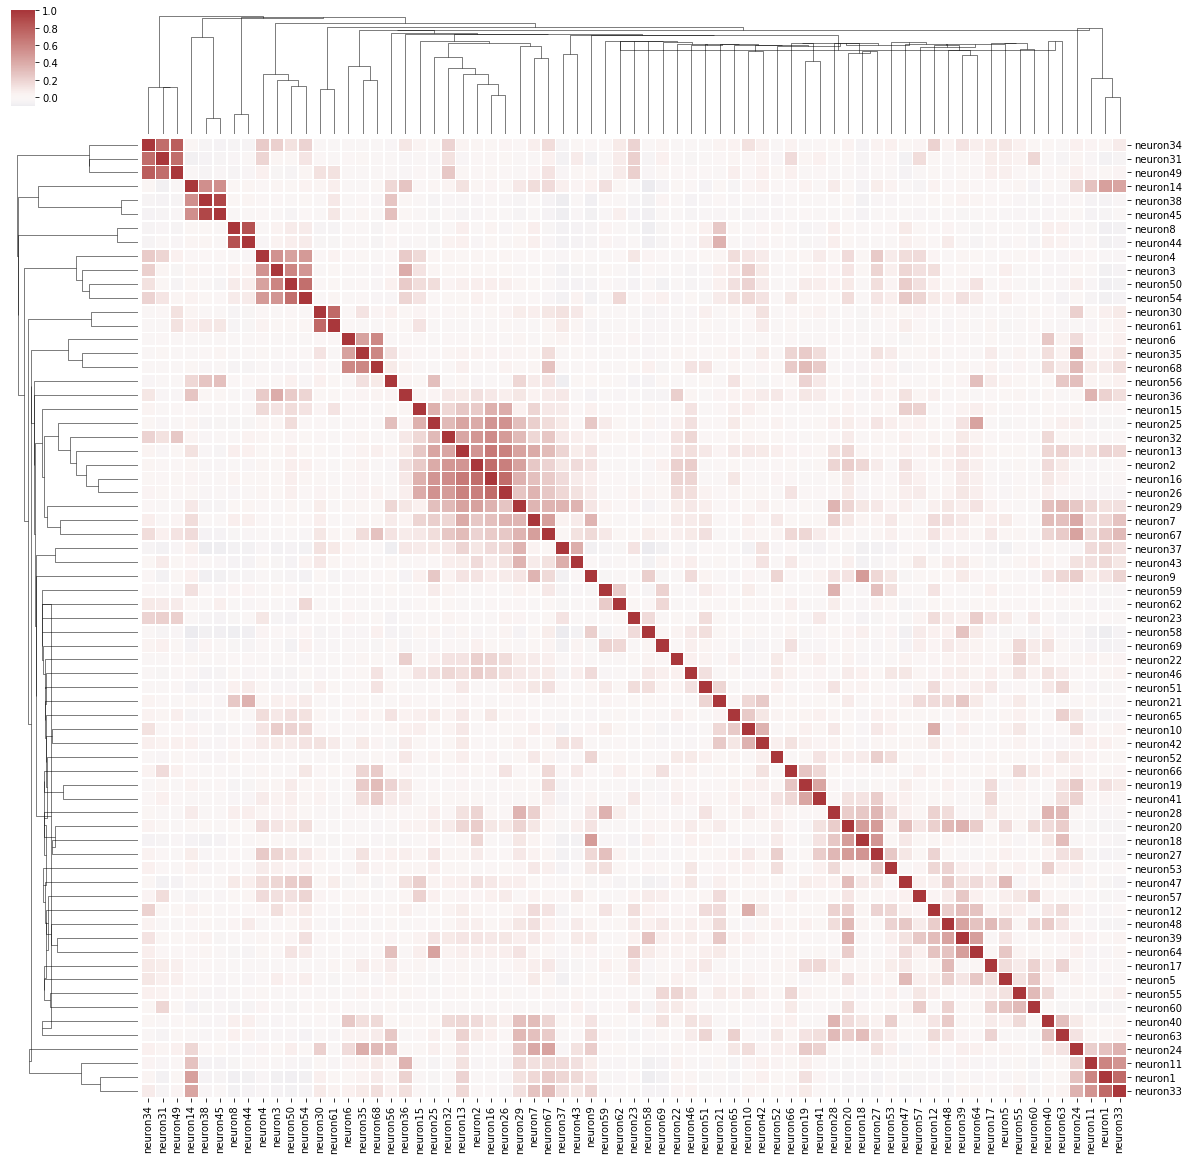

In [9]:
sns.clustermap(cell_transients_dataframe.corr(), center=0, cmap="vlag", linewidths=.75, figsize=(20, 20), method="centroid");

### We create a dataframe that only contains the neurons that had a correlation $\ge 3.0$ with another neuron

In [12]:
correlation_df = pd.DataFrame(columns=[key for key in correlated_pairs_dict], index=set([key for inner_dict in correlated_pairs_dict.values() for key in inner_dict]))
for key in correlated_pairs_dict:
    for value in correlated_pairs_dict[key]:
        correlation_df[key][value] = correlated_pairs_dict[key][value]

In [13]:
# correlation_df

#### A better way to compute the correlation between two neurons:
$$q=\frac{|\vec{n_1} \wedge \vec{n_2}|}{|\vec{n_1} \vee \vec{n_2}|}$$

In [ ]:
# corr_df = cell_transients_dataframe[(cell_transients_dataframe['neuron1'] != 0) b& (cell_transients_dataframe['neuron3'] != 0)]

In [ ]:
# result_dataframe.plot.scatter(x='Trial_time', y='neuron7');

neuron7_list = list()
for i in range(0, result_dataframe['neuron7'].size):
    if result_dataframe['Open2_centerpoint'][i] != 0:
        neuron7_list.append(result_dataframe['neuron7'][i])
    else:
        neuron7_list.append(np.nan)

# neuron7_dataframe = result_dataframe[['Trial time']].copy()
# neuron7_dataframe['neuron7'] = pd.Series(neuron7_list)
# neuron7_dataframe['neuron7'][neuron7_dataframe['neuron7'] > 0]
# neuron7_dataframe['neuron7'] = pd.DataFrame(columns=[n]neuron7_list)
# sns.regplot(x=result_dataframe['Trial time'], y=neuron7_dataframe['neuron7'], color="g");

In [ ]:
FRAME_RATE = 10
run_vector = behavior_df['Running_frames'][behavior_df['Running_frames'] != 0].index.tolist()
no_run_vector = behavior_df['Running_frames'][behavior_df['Running_frames'] == 0].index.tolist()

run_sums = [activity_df[column][run_vector].sum() for column in activity_df]
no_run_sums = [activity_df[column][no_run_vector].sum() for column in activity_df]   

run_sums1 = [FRAME_RATE * run_sums[i] / len(run_vector) for i in range(0, len(run_sums))]
no_run_sums1 = [FRAME_RATE * no_run_sums[i] / len(no_run_vector) for i in range(0, len(no_run_sums))]

run_noruns_dataframe = pd.DataFrame(columns=['runs', 'norun'])
run_noruns_dataframe['runs'] = pd.Series(run_sums1)
run_noruns_dataframe['norun'] = pd.Series(no_run_sums1)
# run_noruns_dataframe.plot.bar(figsize=(17, 5), rot=0);
# data_1 = [Bar(x=run_noruns_dataframe, y=run_noruns_dataframe)]
# plotly.offline.iplot(data_1)